In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("/Users/koohyesung/Documents/cleaned_df_exploration.csv", low_memory=False)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# Selecting columns as specified and filtering the dataset for issue years between 2007 and 2011
columns = [
    'loan_status', 'loan_amnt', 'int_rate', 'emp_length', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_util', 'mort_acc', 'fico_score_change',
    'sub_grade_num', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
    'home_ownership_RENT AND OTHER', 'verification_status_Not Verified',
    'verification_status_Source Verified', 'verification_status_Verified',
    'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
    'purpose_major_purchase', 'purpose_medical', 'application_type_Individual',
    'application_type_Joint App', 'years_of_credit_history'
]
filtered_data = data[(data['issue_year'] >= 2007) & (data['issue_year'] <= 2011)]
filtered_data = filtered_data[columns]

# Splitting the data into features and the target variable
X = filtered_data.drop('loan_status', axis=1)
y = filtered_data['loan_status']

# Splitting the dataset into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Setting up the resampling and the model
smote = SMOTE(random_state=42)
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Creating a pipeline that includes SMOTE and Random Forest
pipeline_rf = Pipeline([
    ('smote', smote),
    ('random_forest', model)
])

# Training the model with the original unbalanced dataset
pipeline_rf.fit(X_train, y_train)

# Predicting probabilities
probabilities_rf = pipeline_rf.predict_proba(X_test)[:, 1]

# Evaluating the model
brier_score_rf = brier_score_loss(y_test, probabilities_rf)
roc_auc_rf = roc_auc_score(y_test, probabilities_rf)
print("Random Forest - Brier Score:", brier_score_rf)
print("Random Forest - ROC AUC Score:", roc_auc_rf)

Random Forest - Brier Score: 0.10080437447523091
Random Forest - ROC AUC Score: 0.8395936176501066


In [4]:
print(probabilities_rf)

[0.04 0.73 0.14 ... 0.04 0.33 0.03]


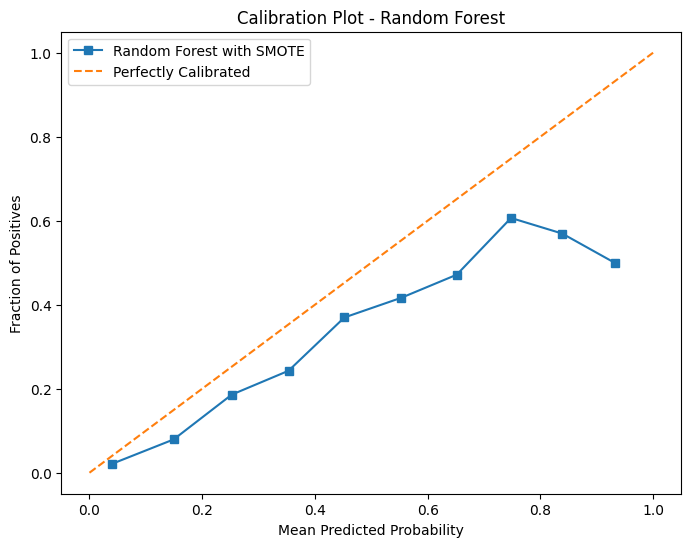

In [5]:
# Calibration curve for simple Random Forest classifier
prob_true_rf, prob_pred_rf = calibration_curve(y_test, probabilities_rf, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_rf, prob_true_rf, marker='s', label='Random Forest with SMOTE')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot - Random Forest')
plt.legend()
plt.show()


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import brier_score_loss, roc_auc_score
from scipy.stats import randint

# Setting up the resampling and the model
smote = SMOTE(random_state=42)
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Creating a pipeline that includes SMOTE and Random Forest
pipeline_rf_tuned = Pipeline([
    ('smote', smote),
    ('random_forest', model)
])

# Define the grid of hyperparameters to search
param_dist_rf = {
    'random_forest__n_estimators': randint(50, 200),  # Random int between 50 and 200
    'random_forest__max_depth': [None, 10, 20],  # Less aggressive than before
    'random_forest__min_samples_split': randint(2, 10),
    'random_forest__min_samples_leaf': randint(1, 4),
    'random_forest__max_features': ['auto', 'sqrt']
}

# Implement RandomizedSearchCV with parallel processing
random_search_rf = RandomizedSearchCV(pipeline_rf_tuned, param_distributions=param_dist_rf, n_iter=100, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1, random_state=42)
random_search_rf.fit(X_train, y_train)

# Best Random Forest model
best_rf_model = random_search_rf.best_estimator_

# Predicting probabilities
probabilities_rf_tuned = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluating the model
brier_score_rf_tuned = brier_score_loss(y_test, probabilities_rf_tuned)
roc_auc_rf_tuned = roc_auc_score(y_test, probabilities_rf_tuned)
print("Tuned Random Forest - Brier Score:", brier_score_rf_tuned)
print("Tuned Random Forest - ROC AUC Score:", roc_auc_rf_tuned)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/koohyesung/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
255 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
175 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/koohyesung/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/koohyesung/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/koohyesung/anaconda3/lib/python3.11/site-packages/imblearn/

Tuned Random Forest - Brier Score: 0.10009809321101057
Tuned Random Forest - ROC AUC Score: 0.8453071253303115


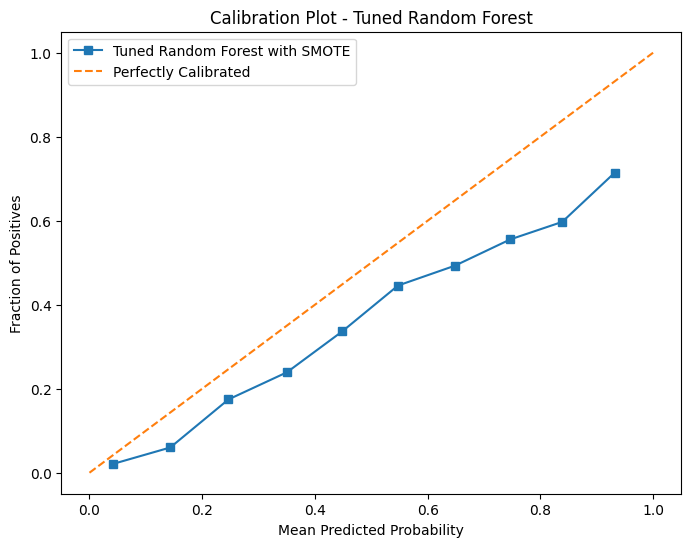

In [9]:
# Calibration curve for tuned Random Forest classifier
prob_true_rf_tuned, prob_pred_rf_tuned = calibration_curve(y_test, probabilities_rf_tuned, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(prob_pred_rf_tuned, prob_true_rf_tuned, marker='s', label='Tuned Random Forest with SMOTE')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot - Tuned Random Forest')
plt.legend()
plt.show()

In [11]:
import joblib

# Save the best model to a file
joblib.dump(best_rf_model, 'best_rf_model.pkl')

print("Model saved as 'best_rf_model.pkl'")


Model saved as 'best_rf_model.pkl'


In [10]:
print(probabilities_rf_tuned)

[0.05666221 0.70706656 0.11485606 ... 0.03740158 0.46924189 0.02678267]


In [12]:

import joblib
import pandas as pd
from sklearn.metrics import brier_score_loss, roc_auc_score

# Load the best RandomForest model from file
loaded_rf_model = joblib.load('best_rf_model.pkl')

# Define the columns used for training, to ensure consistency, plus the columns to retain
feature_columns = [
    'loan_status', 'loan_amnt', 'int_rate', 'emp_length', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'revol_util', 'mort_acc', 'fico_score_change',
    'sub_grade_num', 'home_ownership_MORTGAGE', 'home_ownership_OWN',
    'home_ownership_RENT AND OTHER', 'verification_status_Not Verified',
    'verification_status_Source Verified', 'verification_status_Verified',
    'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
    'purpose_major_purchase', 'purpose_medical', 'application_type_Individual',
    'application_type_Joint App', 'years_of_credit_history'
]
additional_columns = ['issue_year', 'issue_month', 'id']

# Filter the data for issue years between 2012 and 2018 and include additional columns
filtered_data_new = data[(data['issue_year'] >= 2012) & (data['issue_year'] <= 2018)]
filtered_data_new = filtered_data_new[feature_columns + additional_columns]

# Prepare features for model prediction
X_new = filtered_data_new.drop(['loan_status'] + additional_columns, axis=1)
y_new = filtered_data_new['loan_status']

# Predict the probabilities and classes on the new dataset using the loaded model
probabilities_loaded_rf_new = loaded_rf_model.predict_proba(X_new)[:, 1]
predicted_classes_loaded_rf_new = loaded_rf_model.predict(X_new)

# Add predicted probabilities and classes as new columns
filtered_data_new['predicted_probability'] = probabilities_loaded_rf_new
filtered_data_new['predicted_class'] = predicted_classes_loaded_rf_new

# Calculate and print the Brier score loss and ROC AUC score using the loaded model on the new dataset
brier_score_loaded_rf_new = brier_score_loss(y_new, probabilities_loaded_rf_new)
roc_auc_loaded_rf_new = roc_auc_score(y_new, probabilities_loaded_rf_new)
print("Loaded RandomForest on new dataset - Brier Score:", brier_score_loaded_rf_new)
print("Loaded RandomForest on new dataset - ROC AUC Score:", roc_auc_loaded_rf_new)

# Export the enhanced DataFrame with all original columns, plus predictions, to a CSV file
filtered_data_new.to_csv('data_rf_predictions.csv', index=False)
print("Enhanced data with all original columns and predictions has been saved to 'dataset_rf_predictions.csv'.")


Loaded RandomForest on new dataset - Brier Score: 0.09441342997027864
Loaded RandomForest on new dataset - ROC AUC Score: 0.9235056303567754
Enhanced data with all original columns and predictions has been saved to 'dataset_rf_predictions.csv'.


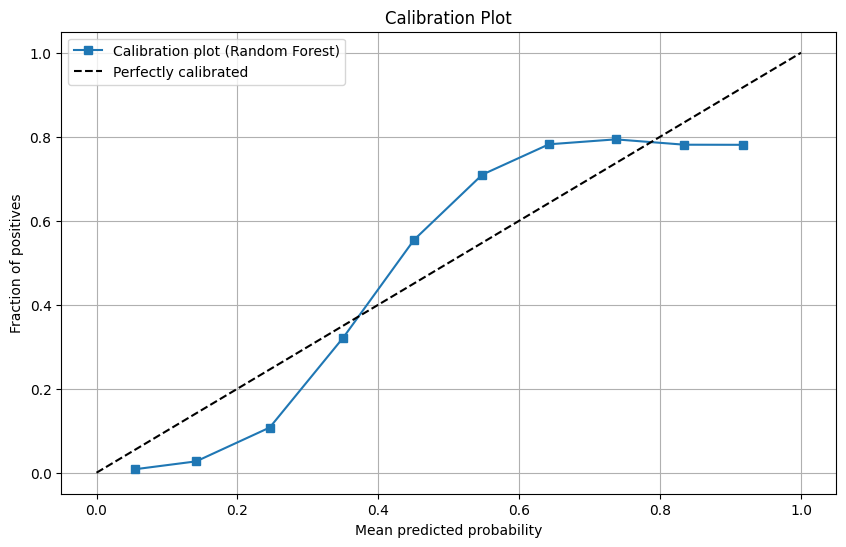

In [19]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Predict the probabilities and actual outcomes
probabilities_loaded_rf_new = loaded_rf_model.predict_proba(X_new)[:, 1]
y_new = filtered_data_new['loan_status']

# Generate the calibration curve data
fraction_of_positives, mean_predicted_value = calibration_curve(y_new, probabilities_loaded_rf_new, n_bins=10)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibration plot (Random Forest)')
plt.plot([0, 1], [0, 1], "k--", label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Plot')
plt.legend(loc='best')
plt.grid(True)
plt.show()



In [4]:
data_rf = pd.read_csv("/Users/koohyesung/Documents/data_rf_predictions.csv", low_memory=False)

In [18]:
data_rf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1304344 entries, 0 to 1304343
Data columns (total 31 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_status                          1304344 non-null  int64  
 1   loan_amnt                            1304344 non-null  float64
 2   int_rate                             1304344 non-null  float64
 3   emp_length                           1304344 non-null  int64  
 4   dti                                  1304344 non-null  float64
 5   delinq_2yrs                          1304344 non-null  float64
 6   open_acc                             1304344 non-null  float64
 7   pub_rec                              1304344 non-null  float64
 8   revol_util                           1304344 non-null  float64
 9   mort_acc                             1304344 non-null  float64
 10  fico_score_change                    1304344 non-null  float64
 11

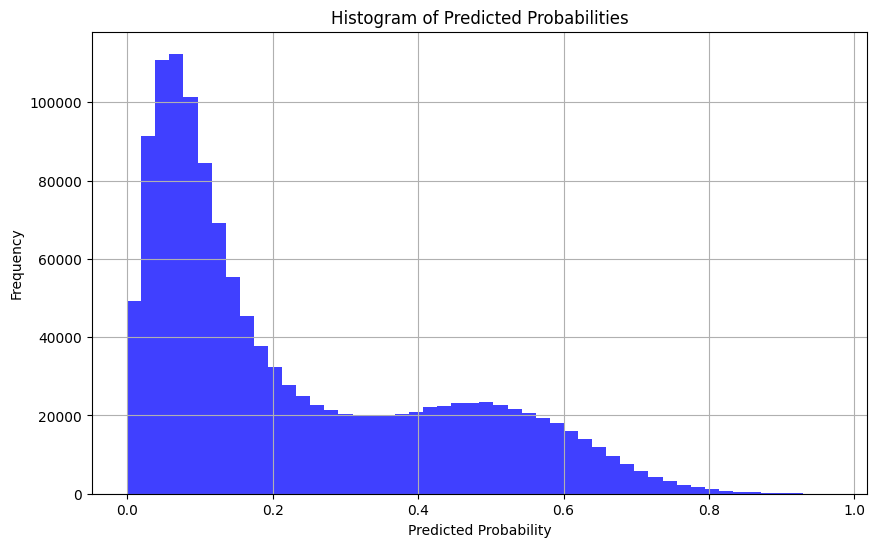

In [5]:

predicted_probs = data_rf['predicted_probability']

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(predicted_probs, bins=50, color='blue', alpha=0.75)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
